**DATA DIRI**

---



> **NAMA** : CANDRA SIDIK DERMAWAN

> **ALAMAT**: Kota Depok, Jawa Barat

> **NO Registrasi** : 0182180121-118


# **Import Libraries**

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from pathlib import Path
from sklearn.model_selection import train_test_split

import tensorflow as tf

from sklearn.metrics import confusion_matrix, classification_report

# **Explore Data**

In [4]:
# install kaggle package
!pip install -q kaggle

In [5]:
# upload kaggle.json
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"candrasd","key":"c382e3a70e57dabd7f8de64a182011b3"}'}

In [6]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

kaggle.json


In [7]:
!kaggle datasets download -d arunrk7/surface-crack-detection

 99% 231M/233M [00:03<00:00, 115MB/s] 
100% 233M/233M [00:03<00:00, 76.8MB/s]


In [8]:
# unzip
!mkdir cracks
!unzip -qq surface-crack-detection.zip -d cracks
!ls cracks

Negative  Positive


In [9]:
positive_dir = Path('/content/cracks/Positive')
negative_dir = Path('/content/cracks/Negative')

# **Creating DataFrames**

In [10]:
def generate_df(image_dir, label):
    filepaths = pd.Series(list(image_dir.glob(r'*.jpg')), name='Filepath').astype(str)
    labels = pd.Series(label, name='Label', index=filepaths.index)
    df = pd.concat([filepaths, labels], axis=1)
    return df

In [11]:
positive_df = generate_df(positive_dir, label="POSITIVE")
negative_df = generate_df(negative_dir, label="NEGATIVE")

all_df = pd.concat([positive_df, negative_df], axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)
all_df

,Filepath,Label
0,/content/cracks/Positive/06417.jpg,POSITIVE
1,/content/cracks/Positive/18204_1.jpg,POSITIVE
2,/content/cracks/Positive/12291_1.jpg,POSITIVE
3,/content/cracks/Negative/05725.jpg,NEGATIVE
4,/content/cracks/Positive/05234.jpg,POSITIVE
...,...,...
39995,/content/cracks/Positive/19746.jpg,POSITIVE
39996,/content/cracks/Negative/13919.jpg,NEGATIVE
39997,/content/cracks/Positive/10622_1.jpg,POSITIVE
39998,/content/cracks/Positive/12212_1.jpg,POSITIVE


In [12]:
train_df, test_df = train_test_split(
    all_df.sample(20000, random_state=1),
    train_size=0.7,
    shuffle=True,
    random_state=1
)

# **Loading Image Data**

In [13]:
train_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

test_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

In [14]:
train_data = train_gen.flow_from_dataframe(
    train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(120, 120),
    color_mode='rgb',
    class_mode='binary',
    batch_size=64,
    shuffle=True,
    seed=42,
    subset='training'
)

val_data = train_gen.flow_from_dataframe(
    train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(120, 120),
    color_mode='rgb',
    class_mode='binary',
    batch_size=64,
    shuffle=True,
    seed=42,
    subset='validation'
)


Found 11200 validated image filenames belonging to 2 classes.
Found 2800 validated image filenames belonging to 2 classes.


# **Model**

In [15]:
inputs = tf.keras.Input(shape=(120, 120, 3))
x = tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu')(inputs)
x = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print(model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 120, 120, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 118, 118, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 59, 59, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 57, 57, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 28, 28, 32)        0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 33    

In [19]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=100,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )
    ]
)

Epoch 1/100
175/175 [==============================] - 120s 684ms/step - loss: 0.0624 - accuracy: 0.9791 - val_loss: 0.0606 - val_accuracy: 0.9779
Epoch 2/100
175/175 [==============================] - 120s 686ms/step - loss: 0.0619 - accuracy: 0.9794 - val_loss: 0.0519 - val_accuracy: 0.9836
Epoch 3/100
175/175 [==============================] - 120s 687ms/step - loss: 0.0647 - accuracy: 0.9785 - val_loss: 0.0554 - val_accuracy: 0.9839
Epoch 4/100
175/175 [==============================] - 121s 692ms/step - loss: 0.0576 - accuracy: 0.9811 - val_loss: 0.0532 - val_accuracy: 0.9825
Epoch 5/100
175/175 [==============================] - 121s 689ms/step - loss: 0.0572 - accuracy: 0.9819 - val_loss: 0.0492 - val_accuracy: 0.9829
Epoch 6/100
175/175 [==============================] - 120s 685ms/step - loss: 0.0579 - accuracy: 0.9817 - val_loss: 0.0502 - val_accuracy: 0.9846
Epoch 7/100
175/175 [==============================] - 120s 685ms/step - loss: 0.0574 - accuracy: 0.9806 - val_loss: 0

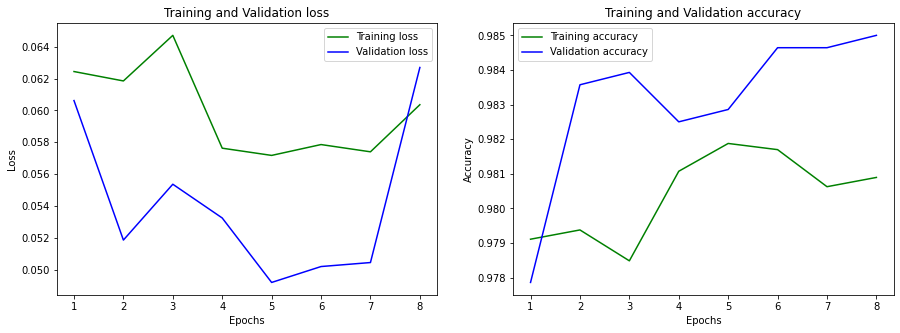

In [20]:
fig = plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1,len(loss_val)+1)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
acc_train = history.history['accuracy']
acc_val = history.history['val_accuracy']
epochs = range(1,len(acc_val)+1)
plt.plot(epochs, acc_train, 'g', label='Training accuracy')
plt.plot(epochs, acc_val, 'b', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [23]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with tf.io.gfile.GFile('model.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmp7qrxi4x7/assets


INFO:tensorflow:Assets written to: /tmp/tmp7qrxi4x7/assets


In [24]:
!ls -la | grep 'model'

-rw-r--r-- 1 root root     23164 Jul  9 07:06 model.tflite
